# Proyek Klasifikasi Gambar: Rice Image Dataset
- **Nama:** Pandu Persada Tanjung
- **Email:** pandupersada73@gmail.com
- **ID Dicoding:** pandupt

  ## Import Semua Packages/Library yang Digunakan

In [ ]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as tq

In [ ]:
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [ ]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Salin kaggle.json
kaggle_json_path = '/content/drive/MyDrive/DBS/kaggle.json'
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
shutil.copy(kaggle_json_path, os.path.expanduser('~/.kaggle/kaggle.json'))
os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)

In [ ]:
!pip install -q kaggle
!kaggle datasets download -d muratkokludataset/rice-image-dataset

Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0
 53% 116M/219M [00:00<00:00, 1.20GB/s]
100% 219M/219M [00:00<00:00, 811MB/s] 


In [ ]:
!unzip -q rice-image-dataset.zip -d rice_dataset

### Data Preprocessing

#### Split Dataset

In [ ]:
# Path ke folder dataset asli
base_dir = "rice_dataset/Rice_Image_Dataset"
selected_classes = ['Basmati', 'Jasmine', 'Ipsala']
samples_per_class = 5000
output_base = "processed_rice_dataset"

In [ ]:
# Buat folder output train/val/test
for split in ['train', 'val', 'test']:
    for cls in selected_classes:
        os.makedirs(os.path.join(output_base, split, cls), exist_ok=True)

In [ ]:
# Fungsi salin gambar
def copy_images(class_name, file_list, split):
    for filename in file_list:
        src_path = os.path.join(base_dir, class_name, filename)
        dst_path = os.path.join(output_base, split, class_name, filename)
        shutil.copy2(src_path, dst_path)

In [ ]:
# Proses per kelas
for cls in selected_classes:
    class_path = os.path.join(base_dir, cls)
    all_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if len(all_files) < samples_per_class:
        raise ValueError(f"Jumlah file di kelas '{cls}' hanya {len(all_files)}, kurang dari {samples_per_class}")

    # Ambil sample acak
    selected_files = random.sample(all_files, samples_per_class)

    # Split 20% test, 80% train+val
    trainval_files, test_files = train_test_split(selected_files, test_size=0.2, random_state=42)

    # Dari 80% trainval → ambil 20% val (berarti 16% dari total)
    train_files, val_files = train_test_split(trainval_files, test_size=0.2, random_state=42)

    # Salin gambar ke folder
    copy_images(cls, train_files, 'train')
    copy_images(cls, val_files, 'val')
    copy_images(cls, test_files, 'test')

In [ ]:
train_ds = image_dataset_from_directory(
    "processed_rice_dataset/train",
    image_size=(150, 150),
    color_mode="grayscale",
    batch_size=32,
    label_mode='categorical'
)

val_ds = image_dataset_from_directory(
    "processed_rice_dataset/val",
    image_size=(150, 150),
    color_mode="grayscale",
    batch_size=32,
    label_mode='categorical'
)

test_ds = image_dataset_from_directory(
    "processed_rice_dataset/test",
    image_size=(150, 150),
    color_mode="grayscale",
    batch_size=32,
    label_mode='categorical'
)

Found 18992 files belonging to 3 classes.
Found 2400 files belonging to 3 classes.
Found 5808 files belonging to 3 classes.


#### Data Checking

In [ ]:
base_path = "processed_rice_dataset/train"

In [ ]:
rice_images = {cls: os.listdir(os.path.join(base_path, cls)) for cls in os.listdir(base_path)}

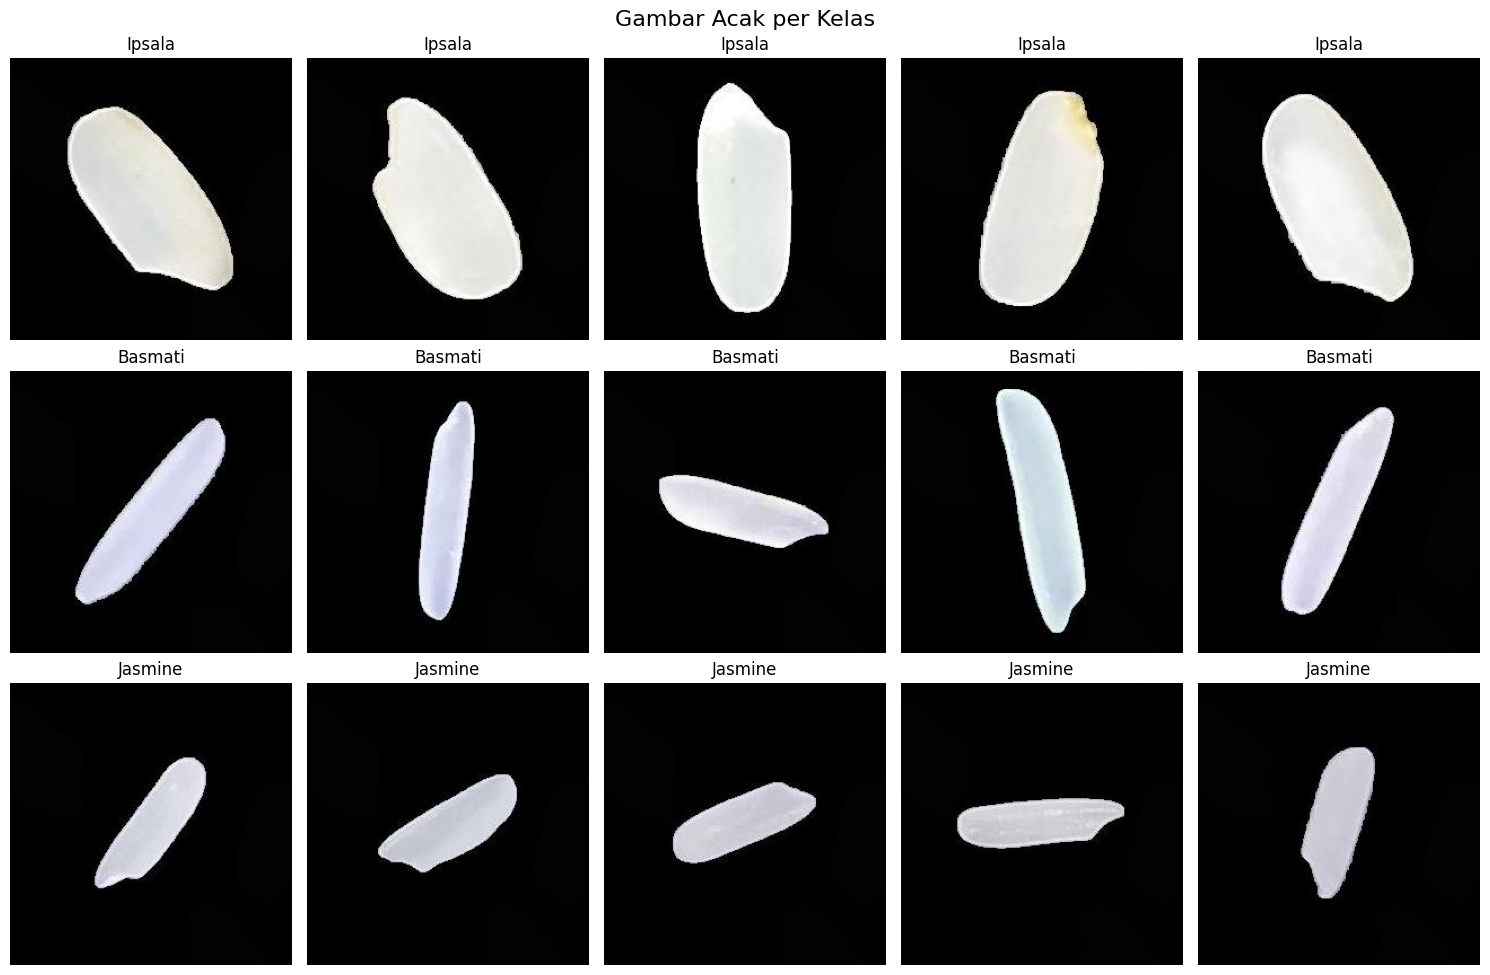

In [ ]:
fig, axs = plt.subplots(len(rice_images), 5, figsize=(15, 10))

for i, (class_name, image_list) in enumerate(rice_images.items()):
    sampled_images = np.random.choice(image_list, 5, replace=False)

    for j, image_name in enumerate(sampled_images):
        img_path = os.path.join(base_path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(class_name)
        axs[i, j].axis('off')

fig.suptitle("Gambar Acak per Kelas", fontsize=16)
plt.tight_layout()
plt.show()

#### Plot Distribution

In [ ]:
lung_path = "processed_rice_dataset/train"

file_name = []
labels = []
full_path = []

In [ ]:
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))
        file_name.append(name)

df_distribution = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

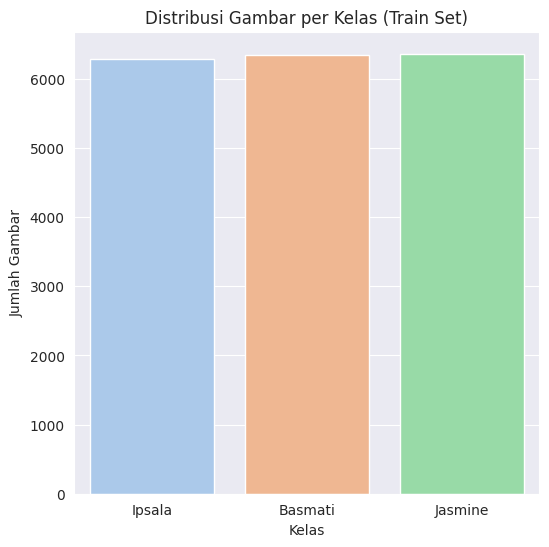

In [ ]:
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
sns.countplot(data=df_distribution, x="labels", palette="pastel")
plt.title("Distribusi Gambar per Kelas (Train Set)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.show()

In [ ]:
lung_path = "processed_rice_dataset/test"

file_name = []
labels = []
full_path = []

In [ ]:
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))
        file_name.append(name)

df_distribution = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

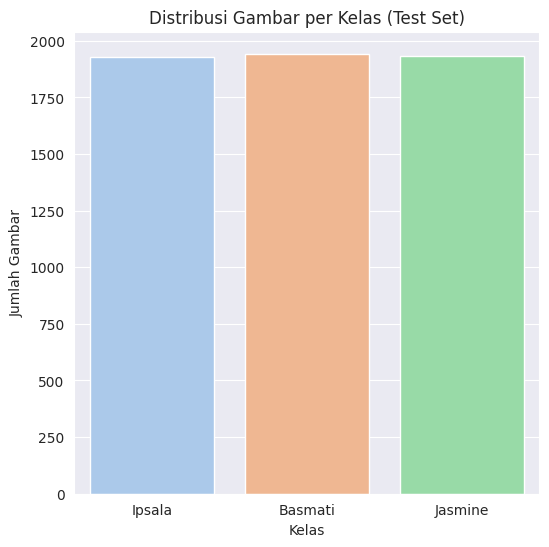

In [ ]:
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
sns.countplot(data=df_distribution, x="labels", palette="pastel")
plt.title("Distribusi Gambar per Kelas (Test Set)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.show()

In [ ]:
val_path = "processed_rice_dataset/val"

file_name = []
labels = []
full_path = []

In [ ]:
for path, subdirs, files in os.walk(val_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))
        file_name.append(name)

# Buat DataFrame distribusi
df_val_distribution = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

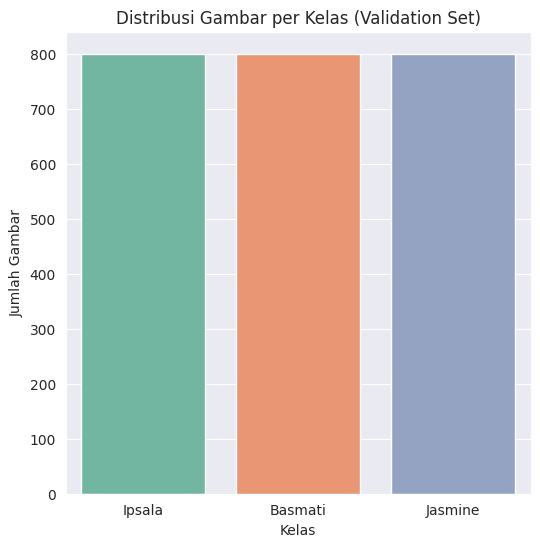

In [ ]:

# Visualisasi distribusi
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
sns.countplot(data=df_val_distribution, x="labels", palette="Set2")
plt.title("Distribusi Gambar per Kelas (Validation Set)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.show()

## Modelling

In [ ]:
import tensorflow as tf
from tensorflow.keras import regularizers

# Bersihkan session
tf.keras.backend.clear_session()

# CNN model dengan regularisasi L2
model_ds = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001),
                  input_shape=(150, 150, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (4, 4), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (7, 7), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),

    layers.Dense(3, activation='softmax')
])

# Compile
model_ds.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,          # stop training jika tidak membaik selama 3 epoch
    restore_best_weights=True,
    verbose=1
)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
history_ds = model_ds.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)


Epoch 1/30
594/594 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.7994 - loss: 1.3832 - val_accuracy: 0.9658 - val_loss: 0.2671
Epoch 2/30
594/594 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.9499 - loss: 0.3131 - val_accuracy: 0.9771 - val_loss: 0.1843
Epoch 3/30
594/594 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.9645 - loss: 0.2256 - val_accuracy: 0.9804 - val_loss: 0.1608
Epoch 4/30
594/594 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9702 - loss: 0.1929 - val_accuracy: 0.9775 - val_loss: 0.1743
Epoch 5/30
594/594 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.9740 - loss: 0.1742 - val_accuracy: 0.9792 - val_loss: 0.1421
Epoch 6/30
594/594 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.9736 - loss: 0.1734 - val_accuracy: 0.9829 - val_loss: 0.1300
Epoch 7/30
594/594 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.9769 - loss: 0.1579 - val_accuracy: 0.9817 - val_loss: 0.1288
Epoch 8/30
594/594 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9756 - loss: 0.1491 - 

In [ ]:
train_loss, train_accuracy = model_ds.evaluate(train_ds, verbose=0)
print(f"Akurasi pada data training: {train_accuracy * 100:.2f}%")

Akurasi pada data training: 98.38%


In [ ]:
test_loss, test_accuracy = model_ds.evaluate(test_ds, verbose=0)
print(f"Akurasi pada data testing: {test_accuracy * 100:.2f}%")

Akurasi pada data testing: 98.12%


## Evaluasi dan Visualisasi

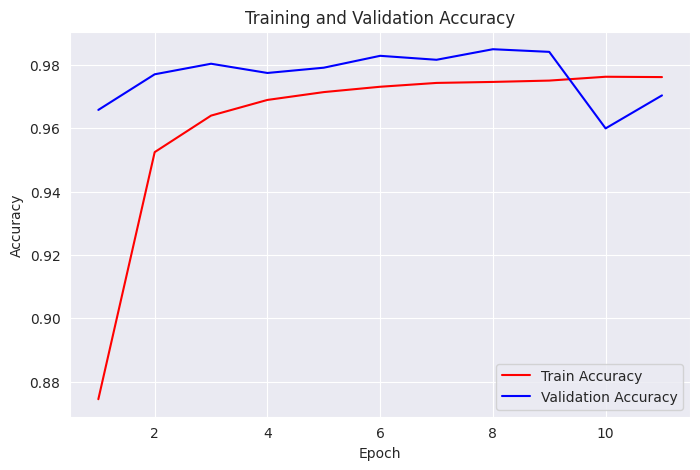

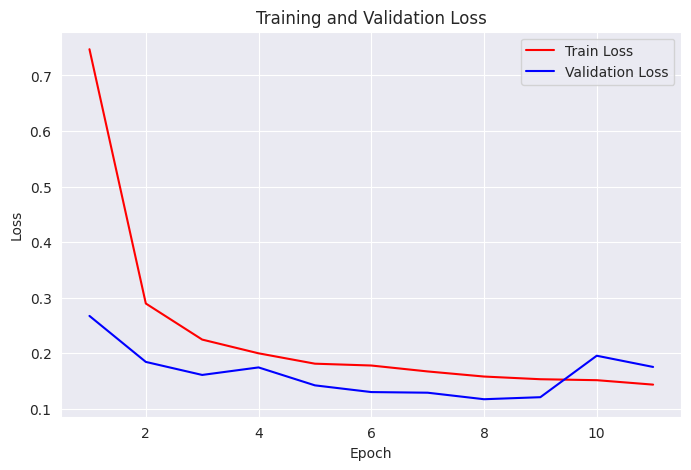

In [ ]:
# Asumsikan history tersimpan di variabel history_ds
acc = history_ds.history['accuracy']
val_acc = history_ds.history['val_accuracy']
loss = history_ds.history['loss']
val_loss = history_ds.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot Akurasi
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
import os

class_names = sorted(os.listdir("processed_rice_dataset/test"))
print("Class names:", class_names)

Class names: ['Basmati', 'Ipsala', 'Jasmine']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━

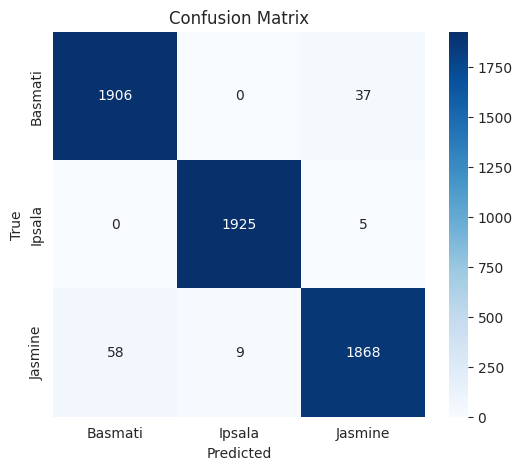

Classification Report:

              precision    recall  f1-score   support

     Basmati       0.97      0.98      0.98      1943
      Ipsala       1.00      1.00      1.00      1930
     Jasmine       0.98      0.97      0.97      1935

    accuracy                           0.98      5808
   macro avg       0.98      0.98      0.98      5808
weighted avg       0.98      0.98      0.98      5808



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model_ds.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

## Konversi Model

#### SavedModel

In [ ]:
# Pastikan direktori ada
import os
os.makedirs("saved_model", exist_ok=True)

model_ds.export("saved_model/rice_model")

Saved artifact at 'saved_model/rice_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135470354608208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135470354612048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135470354611664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135470354610896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135470354609168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135470354609744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135470354608784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135470354611472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135469983876688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135469983876304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13546998

#### TFLite Conversion

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/rice_model")
tflite_model = converter.convert()

os.makedirs("tflite_model", exist_ok=True)

with open("tflite_model/rice_model.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
with open("tflite_model/label.txt", "w") as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")

#### TFJS

In [ ]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format=tf_saved_model \
    saved_model/rice_model tfjs_model/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-05-16 04:12:03.305879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747368723.326927   13701 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attem

## Inference (Optional)

In [ ]:
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model_ds.predict(img_array)
    pred_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)

    print(f"Prediksi: {class_names[pred_class]} ({confidence*100:.2f}%)")

# Contoh penggunaan
predict_image("/content/drive/MyDrive/DBS/cnndataset/JasmineRice.jpg")  # Ganti dengan path file gambarmu

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Prediksi: Jasmine (53.42%)


In [ ]:
!zip -r rice_export.zip saved_model tfjs_model tflite_model requirements.txt

	zip warning: name not matched: requirements.txt
  adding: saved_model/ (stored 0%)
  adding: saved_model/rice_model/ (stored 0%)
  adding: saved_model/rice_model/fingerprint.pb (stored 0%)
  adding: saved_model/rice_model/assets/ (stored 0%)
  adding: saved_model/rice_model/variables/ (stored 0%)
  adding: saved_model/rice_model/variables/variables.index (deflated 70%)
  adding: saved_model/rice_model/variables/variables.data-00000-of-00001 (deflated 4%)
  adding: saved_model/rice_model/saved_model.pb (deflated 87%)
  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard2of2.bin (deflated 4%)
  adding: tfjs_model/model.json (deflated 91%)
  adding: tfjs_model/group1-shard1of2.bin (deflated 4%)
  adding: tflite_model/ (stored 0%)
  adding: tflite_model/rice_model.tflite (deflated 7%)
  adding: tflite_model/label.txt (stored 0%)


In [ ]:
from google.colab import files
files.download("rice_export.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>